## Step 1 Install required packages

In [1]:
!pip install parl==1.3.1
!pip install -U gym
!pip install -U box2d-py

## Step 2 Import required packages

In [2]:
import os
import gym
import numpy as np

import parl
from parl import layers
from paddle import fluid
from parl.utils import logger
from parl.utils import action_mapping 
from parl.utils import ReplayMemory 
from paddle.fluid.param_attr import ParamAttr
from parl.utils.rl_utils import calc_gae, calc_discount_sum_rewards
import matplotlib.pyplot as plt
import scipy.signal

## Step 3 Set parameters

In [ ]:
######################################################################
######################################################################
#
# 1. 请设定超参数，查看效果
#
######################################################################
######################################################################

gamma = 0.99        
lam = 0.98         
kl_targ = 0.003
episodes_per_batch = 20
loss_type = 'CLIP'
train_total_steps = 2e7
test_every_steps = 1e4


## Step 4 Set up Model, Algorithm and Agent

### （1）Model

In [ ]:
class LunarLCModel(parl.Model):
    def __init__(self, obs_dim, act_dim, init_logvar=-1.0):
        self.policy_model = PolicyModel(obs_dim, act_dim, init_logvar)
        self.value_model = ValueModel(obs_dim, act_dim)
        self.policy_lr = self.policy_model.lr
        self.value_lr = self.value_model.lr

    def policy(self, obs):
        return self.policy_model.policy(obs)

    def policy_sample(self, obs):
        return self.policy_model.sample(obs)

    def value(self, obs):
        return self.value_model.value(obs)


class PolicyModel(parl.Model):
    def __init__(self, obs_dim, act_dim, init_logvar):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        hid1_size = obs_dim * 20
        hid3_size = act_dim * 20
        hid2_size = int(np.sqrt(hid1_size * hid3_size))

        self.lr = 5e-4 / np.sqrt(hid2_size)

        self.fc1 = layers.fc(size=hid1_size, act='tanh')
        self.fc2 = layers.fc(size=hid2_size, act='tanh')
        self.fc3 = layers.fc(size=hid3_size, act='tanh')
        self.fc4 = layers.fc(size=act_dim, act='tanh')

        self.logvars = layers.create_parameter(
            shape=[act_dim],
            dtype='float32',
            default_initializer=fluid.initializer.ConstantInitializer(
                init_logvar))

    def policy(self, obs):
        hid1 = self.fc1(obs)
        hid2 = self.fc2(hid1)
        hid3 = self.fc3(hid2)
        means = self.fc4(hid3)
        logvars = self.logvars()
        return means, logvars

    def sample(self, obs):
        means, logvars = self.policy(obs)
        sampled_act = means + (
            layers.exp(logvars / 2.0) *  # stddev
            layers.gaussian_random(shape=(self.act_dim, ), dtype='float32'))
        return sampled_act


class ValueModel(parl.Model):
    def __init__(self, obs_dim, act_dim):
        super(ValueModel, self).__init__()
        hid1_size = obs_dim * 20
        hid3_size = 10
        hid2_size = int(np.sqrt(hid1_size * hid3_size))

        self.lr = 1e-3 / np.sqrt(hid2_size)

        self.fc1 = layers.fc(size=hid1_size, act='tanh')
        self.fc2 = layers.fc(size=hid2_size, act='tanh')
        self.fc3 = layers.fc(size=hid3_size, act='tanh')
        self.fc4 = layers.fc(size=1)

    def value(self, obs):
        hid1 = self.fc1(obs)
        hid2 = self.fc2(hid1)
        hid3 = self.fc3(hid2)
        V = self.fc4(hid3)
        V = layers.squeeze(V, axes=[])
        return V

### （2）Algorithm

In [ ]:
from parl.algorithms import PPO

### （3）Agent

In [ ]:
class LunarLCAgent(parl.Agent):
    def __init__(self,
                 algorithm,
                 obs_dim,
                 act_dim,
                 kl_targ,
                 loss_type,
                 beta=1.0,
                 epsilon=0.2,
                 policy_learn_times=20,
                 value_learn_times=10,
                 value_batch_size=256):
        self.alg = algorithm
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        assert loss_type == 'CLIP' or loss_type == 'KLPEN'
        self.loss_type = loss_type
        super(LunarLCAgent, self).__init__(algorithm)

        self.policy_learn_times = policy_learn_times
        # Adaptive kl penalty coefficient
        self.beta = beta
        self.kl_targ = kl_targ

        self.value_learn_times = value_learn_times
        self.value_batch_size = value_batch_size
        self.value_learn_buffer = None

    def build_program(self):
        self.policy_predict_program = fluid.Program()
        self.policy_sample_program = fluid.Program()
        self.policy_learn_program = fluid.Program()
        self.value_predict_program = fluid.Program()
        self.value_learn_program = fluid.Program()

        with fluid.program_guard(self.policy_sample_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            sampled_act = self.alg.sample(obs)
            self.policy_sample_output = [sampled_act]

        with fluid.program_guard(self.policy_predict_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            means = self.alg.predict(obs)
            self.policy_predict_output = [means]

        with fluid.program_guard(self.policy_learn_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            actions = layers.data(
                name='actions', shape=[self.act_dim], dtype='float32')
            advantages = layers.data(
                name='advantages', shape=[1], dtype='float32')
            if self.loss_type == 'KLPEN':
                beta = layers.data(name='beta', shape=[], dtype='float32')
                loss, kl = self.alg.policy_learn(obs, actions, advantages,
                                                 beta)
            else:
                loss, kl = self.alg.policy_learn(obs, actions, advantages)

            self.policy_learn_output = [loss, kl]

        with fluid.program_guard(self.value_predict_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            value = self.alg.value_predict(obs)
            self.value_predict_output = [value]

        with fluid.program_guard(self.value_learn_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            val = layers.data(name='val', shape=[], dtype='float32')
            value_loss = self.alg.value_learn(obs, val)
            self.value_learn_output = [value_loss]

    def policy_sample(self, obs):
        feed = {'obs': obs}
        sampled_act = self.fluid_executor.run(
            self.policy_sample_program,
            feed=feed,
            fetch_list=self.policy_sample_output)[0]
        return sampled_act

    def policy_predict(self, obs):
        feed = {'obs': obs}
        means = self.fluid_executor.run(
            self.policy_predict_program,
            feed=feed,
            fetch_list=self.policy_predict_output)[0]
        return means

    def value_predict(self, obs):
        feed = {'obs': obs}
        value = self.fluid_executor.run(
            self.value_predict_program,
            feed=feed,
            fetch_list=self.value_predict_output)[0]
        return value

    def _batch_policy_learn(self, obs, actions, advantages):
        if self.loss_type == 'KLPEN':
            feed = {
                'obs': obs,
                'actions': actions,
                'advantages': advantages,
                'beta': self.beta
            }
        else:
            feed = {'obs': obs, 'actions': actions, 'advantages': advantages}
        [loss, kl] = self.fluid_executor.run(
            self.policy_learn_program,
            feed=feed,
            fetch_list=self.policy_learn_output)
        return loss, kl

    def _batch_value_learn(self, obs, val):
        feed = {'obs': obs, 'val': val}
        value_loss = self.fluid_executor.run(
            self.value_learn_program,
            feed=feed,
            fetch_list=self.value_learn_output)[0]
        return value_loss

    def policy_learn(self, obs, actions, advantages):
        """ Learn policy:
        1. Sync parameters of policy model to old policy model
        2. Fix old policy model, and learn policy model multi times
        3. if use KLPEN loss, Adjust kl loss coefficient: beta
        """
        self.alg.sync_old_policy()

        all_loss, all_kl = [], []
        for _ in range(self.policy_learn_times):
            loss, kl = self._batch_policy_learn(obs, actions, advantages)
            all_loss.append(loss)
            all_kl.append(kl)

        if self.loss_type == 'KLPEN':
            # Adative KL penalty coefficient
            if kl > self.kl_targ * 2:
                self.beta = 1.5 * self.beta
            elif kl < self.kl_targ / 2:
                self.beta = self.beta / 1.5

        return np.mean(all_loss), np.mean(all_kl)

    def value_learn(self, obs, value):
        """ Fit model to current data batch + previous data batch
        """
        data_size = obs.shape[0]

        if self.value_learn_buffer is None:
            obs_train, value_train = obs, value
        else:
            obs_train = np.concatenate([obs, self.value_learn_buffer[0]])
            value_train = np.concatenate([value, self.value_learn_buffer[1]])
        self.value_learn_buffer = (obs, value)

        all_loss = []
        for _ in range(self.value_learn_times):
            random_ids = np.arange(obs_train.shape[0])
            np.random.shuffle(random_ids)
            shuffle_obs_train = obs_train[random_ids]
            shuffle_value_train = value_train[random_ids]
            start = 0
            while start < data_size:
                end = start + self.value_batch_size
                value_loss = self._batch_value_learn(
                    shuffle_obs_train[start:end, :],
                    shuffle_value_train[start:end])
                all_loss.append(value_loss)
                start += self.value_batch_size
        return np.mean(all_loss)
    def save(self, save_path, mode, program=None):
        """Save parameters.
        Args:
            save_path(str): where to save the parameters.
            program(fluid.Program): program that describes the neural network structure. If None, will use self.learn_program.
        Raises:
            ValueError: if program is None and self.learn_program does not exist.
        Example:
        .. code-block:: python
            agent = AtariAgent()
            agent.save('./model.ckpt')
        """
        if mode == "policy_sample":
            save_program = self.policy_sample_program
        elif mode == "policy_predict":
            save_program = self.policy_predict_program
        elif mode == "policy_learn":
            save_program = self.policy_learn_program
        elif mode == "value_predict":
            save_program = self.value_predict_program
        elif mode == "value_learn":
            save_program = self.value_learn_program
        else:
            save_program = self.value_predict_program
        if program is None:
            program = save_program
        dirname = os.sep.join(save_path.split(os.sep)[:-1])
        filename = save_path.split(os.sep)[-1]
        fluid.io.save_params(
            executor=self.fluid_executor,
            dirname=dirname,
            main_program=program,
            filename=filename)

    def restore(self, save_path, mode, program=None):
        """Restore previously saved parameters.
        This method requires a program that describes the network structure.
        The save_path argument is typically a value previously passed to ``save_params()``.
        Args:
            save_path(str): path where parameters were previously saved.
            program(fluid.Program): program that describes the neural network structure. If None, will use self.learn_program.
        Raises:
            ValueError: if program is None and self.learn_program does not exist.
        Example:
        .. code-block:: python
            agent = AtariAgent()
            agent.save('./model.ckpt')
            agent.restore('./model.ckpt')
        """
        if mode == "policy_sample":
            save_program = self.policy_sample_program
        elif mode == "policy_predict":
            save_program = self.policy_predict_program
        elif mode == "policy_learn":
            save_program = self.policy_learn_program
        elif mode == "value_predict":
            save_program = self.value_predict_program
        elif mode == "value_learn":
            save_program = self.value_learn_program
        else:
            save_program = self.value_predict_program 
        if program is None:
            program = save_program
        if type(program) is fluid.compiler.CompiledProgram:
            program = program._init_program
        dirname = os.sep.join(save_path.split(os.sep)[:-1])
        filename = save_path.split(os.sep)[-1]
        fluid.io.load_params(
            executor=self.fluid_executor,
            dirname=dirname,
            main_program=program,
            filename=filename)

## Step 5 Training && Test

In [ ]:
class Scaler(object):
    """ Generate scale and offset based on running mean and stddev along axis=0
        offset = running mean
        scale = 1 / (stddev + 0.1) / 3 (i.e. 3x stddev = +/- 1.0)
    """

    def __init__(self, obs_dim):
        """
        Args:
            obs_dim: dimension of axis=1
        """
        self.vars = np.zeros(obs_dim)
        self.means = np.zeros(obs_dim)
        self.cnt = 0
        self.first_pass = True

    def update(self, x):
        """ Update running mean and variance (this is an exact method)
        Args:
            x: NumPy array, shape = (N, obs_dim)
        see: https://stats.stackexchange.com/questions/43159/how-to-calculate-pooled-
               variance-of-two-groups-given-known-group-variances-mean
        """
        if self.first_pass:
            self.means = np.mean(x, axis=0)
            self.vars = np.var(x, axis=0)
            self.cnt = x.shape[0]
            self.first_pass = False
        else:
            n = x.shape[0]
            new_data_var = np.var(x, axis=0)
            new_data_mean = np.mean(x, axis=0)
            new_data_mean_sq = np.square(new_data_mean)
            new_means = (
                (self.means * self.cnt) + (new_data_mean * n)) / (self.cnt + n)
            self.vars = (((self.cnt * (self.vars + np.square(self.means))) +
                          (n * (new_data_var + new_data_mean_sq))) /
                         (self.cnt + n) - np.square(new_means))
            self.vars = np.maximum(
                0.0, self.vars)  # occasionally goes negative, clip
            self.means = new_means
            self.cnt += n

    def get(self):
        """ returns 2-tuple: (scale, offset) """
        return 1 / (np.sqrt(self.vars) + 0.1) / 3, self.means

In [ ]:
def run_train_episode(env, agent, scaler):
    obs = env.reset()
    observes, actions, rewards, unscaled_obs = [], [], [], []
    step = 0.0
    scale, offset = scaler.get()
    scale[-1] = 1.0  # don't scale time step feature
    offset[-1] = 0.0  # don't offset time step feature
    while True:
        obs = obs.reshape((1, -1))
        obs = np.append(obs, [[step]], axis=1)  # add time step feature
        unscaled_obs.append(obs)
        obs = (obs - offset) * scale  # center and scale observations
        obs = obs.astype('float32')
        observes.append(obs)

        action = agent.policy_sample(obs)
        action = np.clip(action, -1.0, 1.0)
        action = action_mapping(action, env.action_space.low[0],
                                env.action_space.high[0])

        action = action.reshape((1, -1)).astype('float32')
        actions.append(action)

        obs, reward, done, _ = env.step(np.squeeze(action))
        rewards.append(reward)
        step += 1e-3  # increment time step feature

        if done:
            break

    return (np.concatenate(observes), np.concatenate(actions),
            np.array(rewards, dtype='float32'), np.concatenate(unscaled_obs))


def run_evaluate_episode(env, agent, scaler, render=False):
    obs = env.reset()
    rewards = []
    step = 0.0
    scale, offset = scaler.get()
    scale[-1] = 1.0  # don't scale time step feature
    offset[-1] = 0.0  # don't offset time step feature
    while True:
        obs = obs.reshape((1, -1))
        obs = np.append(obs, [[step]], axis=1)  # add time step feature
        obs = (obs - offset) * scale  # center and scale observations
        obs = obs.astype('float32')

        action = agent.policy_predict(obs)
        action = action_mapping(action, env.action_space.low[0],
                                env.action_space.high[0])

        obs, reward, done, _ = env.step(np.squeeze(action))
        rewards.append(reward)

        step += 1e-3  # increment time step feature
        if render:
            env.render()
        if done:
            break
    return np.sum(rewards)


def collect_trajectories(env, agent, scaler, episodes):
    trajectories, all_unscaled_obs = [], []
    for e in range(episodes):
        obs, actions, rewards, unscaled_obs = run_train_episode(
            env, agent, scaler)
        trajectories.append({
            'obs': obs,
            'actions': actions,
            'rewards': rewards,
        })
        all_unscaled_obs.append(unscaled_obs)
    # update running statistics for scaling observations
    scaler.update(np.concatenate(all_unscaled_obs))
    return trajectories

def build_train_data(trajectories, agent):
    train_obs, train_actions, train_advantages, train_discount_sum_rewards = [], [], [], []
    for trajectory in trajectories:
        pred_values = agent.value_predict(trajectory['obs'])

        # scale rewards
        scale_rewards = trajectory['rewards'] * (1 - gamma)

        discount_sum_rewards = calc_discount_sum_rewards(
            scale_rewards, gamma).astype('float32')

        advantages = calc_gae(scale_rewards, pred_values, 0, gamma,
                              lam)

        # normalize advantages
        advantages = (advantages - advantages.mean()) / (
            advantages.std() + 1e-6)
        advantages = advantages.astype('float32')

        train_obs.append(trajectory['obs'])
        train_actions.append(trajectory['actions'])
        train_advantages.append(advantages)
        train_discount_sum_rewards.append(discount_sum_rewards)

    train_obs = np.concatenate(train_obs)
    train_actions = np.concatenate(train_actions)
    train_advantages = np.concatenate(train_advantages)
    train_discount_sum_rewards = np.concatenate(train_discount_sum_rewards)

    return train_obs, train_actions, train_advantages, train_discount_sum_rewards

In [ ]:
all_train_rewards=[]
all_test_rewards=[]
all_train_steps=[]
all_test_steps=[]

def draw_process(title,step,reward,label, color):
    plt.title(title, fontsize=24)
    plt.xlabel("episode", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(step, reward,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

## Step 6 Start training and evaluating

In [3]:
env = gym.make('LunarLanderContinuous-v2')

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
obs_dim += 1  # add 1 to obs dim for time step feature

scaler = Scaler(obs_dim)

model = LunarLCModel(obs_dim, act_dim)
alg = PPO(
    model,
    act_dim=act_dim,
    policy_lr=model.policy_lr,
    value_lr=model.value_lr)
agent = LunarLCAgent(
    alg, obs_dim, act_dim, kl_targ, loss_type=loss_type)

In [4]:
collect_trajectories(env, agent, scaler, episodes=5)

test_flag = 0
total_steps = 0
prev_eval_reward = 100
while total_steps < train_total_steps:
    trajectories = collect_trajectories(
        env, agent, scaler, episodes=episodes_per_batch)
    total_steps += sum([t['obs'].shape[0] for t in trajectories])
    total_train_rewards = sum([np.sum(t['rewards']) for t in trajectories])

    all_train_rewards.append(total_train_rewards)

    train_obs, train_actions, train_advantages, train_discount_sum_rewards = build_train_data(
        trajectories, agent)

    policy_loss, kl = agent.policy_learn(train_obs, train_actions,
                                            train_advantages)
    value_loss = agent.value_learn(train_obs, train_discount_sum_rewards)

    # logger.info(
    #     'Steps {}, Train reward: {}, Policy loss: {}, KL: {}, Value loss: {}'
    #     .format(total_steps, total_train_rewards / args.episodes_per_batch,
    #             policy_loss, kl, value_loss))

    all_train_rewards.append(total_train_rewards / episodes_per_batch)

    if total_steps // test_every_steps >= test_flag:
        while total_steps // test_every_steps >= test_flag:
            test_flag += 1
        eval_reward = run_evaluate_episode(env, agent, scaler)
        all_test_rewards.append(eval_reward)
        logger.info('Steps {}, Evaluate reward: {}'.format(
            total_steps, eval_reward))
        if eval_reward > prev_eval_reward:
            prev_eval_reward = eval_reward
            ckpt = 'steps_{}_reward_{}.ckpt'.format(total_steps, int(eval_reward))
            agent.save(save_path='lunar_models/policy_predict/'+ckpt, mode='policy_predict')
            agent.save(save_path='lunar_models/policy_sample/'+ckpt, mode='policy_sample')
            agent.save(save_path='lunar_models/policy_learn/'+ckpt, mode='policy_learn')
            agent.save(save_path='lunar_models/value_predict/'+ckpt, mode='value_predict')
            agent.save(save_path='lunar_models/value_learn/'+ckpt, mode='value_learn')
agent.save(save_path='lunar_models/final.ckpt', mode='value_predict') 

In [ ]:
all_train_steps = [i for i in range(len(all_train_rewards))]
all_test_steps = [i for i in range(len(all_test_rewards))]

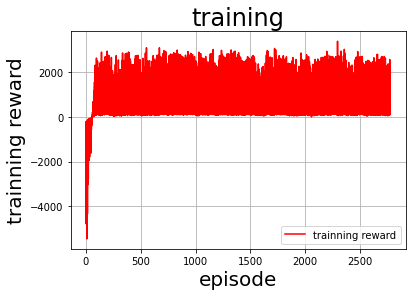

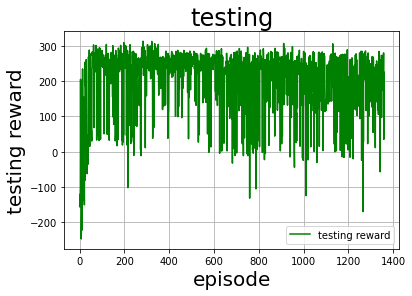

In [ ]:
draw_process("training",all_train_steps,all_train_rewards,"trainning reward", "red") 
draw_process("testing",all_test_steps,all_test_rewards,"testing reward", "green") 

## Step 7 Testing

In [ ]:
def evaluate(env, agent, scaler, render=False):
    average_rewards = []
    for i in range(5):
        obs = env.reset()
        rewards = []
        step = 0.0
        scale, offset = scaler.get()
        scale[-1] = 1.0  # don't scale time step feature
        offset[-1] = 0.0  # don't offset time step feature
        while True:
            obs = obs.reshape((1, -1))
            obs = np.append(obs, [[step]], axis=1)  # add time step feature
            obs = (obs - offset) * scale  # center and scale observations
            obs = obs.astype('float32')

            action = agent.policy_predict(obs)
            action = action_mapping(action, env.action_space.low[0],
                                    env.action_space.high[0])

            obs, reward, done, _ = env.step(np.squeeze(action))
            rewards.append(reward)

            step += 1e-3  # increment time step feature
            if render:
                env.render()
            if done:
                break
        average_rewards.append(np.sum(rewards))
    return np.mean(average_rewards)

In [ ]:
######################################################################
######################################################################
#
# 选择训练好的一次模型文件做评估
#
######################################################################
######################################################################
ckpt = 'lunar_models/final.ckpt'  # 还可以设置ckpt为你训练中效果最好的一次评估保存的模型文件名称

agent.restore(ckpt, mode='value_predict')
evaluate_reward = evaluate(env, agent, scaler, render=True)
logger.info('Evaluate reward: {}'.format(evaluate_reward)) # 打印评估的reward

[06-30 08:08:08 MainThread @<ipython-input-23-781f5d232c20>:12] Evaluate reward: 222.77485365523177
